# Assignment 9

### Import libraries

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import plotly.graph_objs as plotly  # for interactive plots

import tensorflow as tf
from tensorflow.keras.datasets import imdb

---
### Step 1: Data ingestion

In this lab, you'll train a <span style="color:chocolate">sentiment</span> classifier for movie reviews.

* The input is the text of a movie review;
* The output is the probability the input is a positive review.
* The target labels are binary, 0 for negative and 1 for positive.

The data includes 50,000 movie reviews on IMDB. The data comes pre-segmented into train and test splits. The [data loading function](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data) below also splits each input text into tokens (words), and maps the words to integer values. Each input is a sequence of integers corresponding to the words.

In [ ]:
# read data
(X_train, Y_train), (X_test, Y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

print("X_train.shape:", X_train.shape)
print("Y_train.shape:", Y_train.shape)
print("X_test.shape:", X_test.shape)
print("Y_test.shape:", Y_test.shape)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train.shape: (25000,)
Y_train.shape: (25000,)
X_test.shape: (25000,)
Y_test.shape: (25000,)


---
### Step 2: Data preprocessing

Let's have a look at the first training example:

In [ ]:
print('First training example data:', X_train[0])
print('First training example label:', Y_train[0])

First training example data: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
First t

As you can see, the first training example is a positive review. However, that sequence of integer IDs is hard to read.

The data loader provides a dictionary mapping words to IDs. Let's create a reverse index.


In [ ]:
# The imdb dataset comes with an index mapping words to integers.
# In the index the words are ordered by frequency they occur.
index = imdb.get_word_index()

# Because we used index_from=3 (above), setting aside ids below 3 for special
# symbols, we need to add 3 to the index values.
index = dict([(key, value+3) for (key, value) in index.items()])

# Create a reverse index so we can lookup tokens assigned to each id.
reverse_index = dict([(value, key) for (key, value) in index.items()])
reverse_index[1] = '<START>'  # start of input
reverse_index[2] = '#'        # out-of-vocabulary (OOV)
reverse_index[3] = '<UNUSED>'

max_id = max(reverse_index.keys())
print('Largest ID:', max_id)

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Largest ID: 88587


Note that our index (and reverse index) have <span style="color:chocolate">88,587</span> tokens. That's quite <span style="color:chocolate">a large vocabulary</span>!

Next, let's write a decoding function for our data.

In [ ]:
def decode(token_ids):
  """Return a string with the decoded text given a list of token ids."""
  # Try looking up each id in the index, but return '#' (for OOV) if not found.
  tokens = [reverse_index.get(i, "#") for i in token_ids]

  # Connect the string tokens with a space.
  return ' '.join(tokens)

# Show the ids corresponding tokens in the first example.
print(X_train[0])
print(decode(X_train[0]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
<START> this film was just brilliant

---
### Step 3: Exploratory Data Analysis (EDA)

### <span style="color:chocolate">Exercise 1:</span> Text lengths (10 points)

Using the training reviews data, answer the following questions:

1. What are the minimum, maximum, and mean lengths of positive and negative reviews?
2. Create a histogram to visualize the distribution of positive and negative review lengths. Make sure to provide a descriptive title and axis labels.

Positive Review Minimum Length:  11
Positive Review Maximum Length:  1571
Positive Review Mean Length:  235.86432
Negative Review Minimum Length:  13
Negative Review Maximum Length:  2494
Negative Review Mean Length:  241.56296


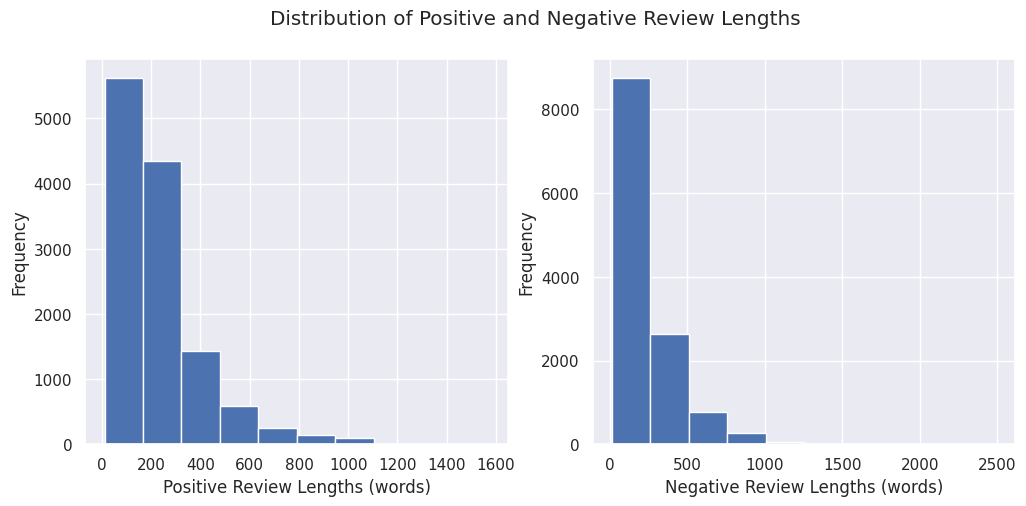

In [ ]:
#find all lengths
review_lengths = []
for review in X_train:
  review_lengths.append(len(review))

review_lengths = np.array(review_lengths)

#find negative and positive indeces and make two separate length arrays
positive_review_ind = np.where(Y_train == 0)[0].astype(int)
negative_review_ind = np.where(Y_train == 1)[0].astype(int)

positive_lengths = review_lengths[positive_review_ind]
negative_lengths = review_lengths[negative_review_ind]

#find minimum maximum and mean lengths of positive and negative reviews
print("Positive Review Minimum Length: ", min(positive_lengths))
print("Positive Review Maximum Length: ", max(positive_lengths))
print("Positive Review Mean Length: ", np.average(positive_lengths))
print("Negative Review Minimum Length: ", min(negative_lengths))
print("Negative Review Maximum Length: ", max(negative_lengths))
print("Negative Review Mean Length: ", np.average(negative_lengths))

#create histogram to visualize distribution of positive and negative review lengths
fig, axes = plt.subplots(1,2,figsize=(12,5))
axes[0].hist(positive_lengths, bins=10)
axes[0].set_ylabel("Frequency")
axes[0].set_xlabel("Positive Review Lengths (words)")
axes[1].hist(negative_lengths, bins=10)
axes[1].set_ylabel("Frequency")
axes[1].set_xlabel("Negative Review Lengths (words)")
plt.suptitle("Distribution of Positive and Negative Review Lengths")
plt.show()

### <span style="color:chocolate">Exercise 2:</span> Token counts (10 points)

Using the training data, create a table listing the counts of positive and negative examples that contain each token provided below.

In [ ]:
tokens = ['good', 'bad', 'amazing', 'boring', 'laugh', 'cry']

# find int value that corresponds to each token
tokens_int = []
for t in tokens:
  tokens_int.append(index.get(t))

# get array of positive and negative reviews
positive_reviews = X_train[positive_review_ind]
negative_reviews = X_train[negative_review_ind]

# check which positive and negative reviews have the required words
positive_tokens_indices = []
negative_tokens_indices = []

for i,t in enumerate(tokens):

  pos_indices = [idx for idx, review in enumerate(positive_reviews) if tokens_int[i] in review]
  neg_indices = [idx for idx, review in enumerate(negative_reviews) if tokens_int[i] in review]

  positive_tokens_indices.append(pos_indices)
  negative_tokens_indices.append(neg_indices)

# finding the counts based on the indeces
positive_tokens_counts = [len(indices) for indices in positive_tokens_indices]
negative_tokens_counts = [len(indices) for indices in negative_tokens_indices]

# create the table
token_table = pd.DataFrame({
    'Token': tokens,
    'Positive Reviews': positive_tokens_counts,
    'Negative Reviews': negative_tokens_counts
})

token_table['Total'] = token_table['Positive Reviews'] + token_table['Negative Reviews']

print(token_table)

     Token  Positive Reviews  Negative Reviews  Total
0     good              4849              4767   9616
1      bad              4396              1491   5887
2  amazing               240               868   1108
3   boring              1205               301   1506
4    laugh               685               525   1210
5      cry               114               231    345


---
### Step 4: Data preprocessing (cont'd)

As is clear from the review length histogram, the current representation of the review text is a variable-length array. Since fixed-length arrays are easier to work with in Tensorflow, you will add special padding tokens at the end of each review until they are all the same length. You will also truncate all training inputs to a specified length.

### <span style="color:chocolate">Exercise 3:</span> Reduced length and padding (10 points)

Fill in the <span style="color:green">NotImplemented</span> parts of the <span style="color:chocolate">truncate_pad_data()</span> function below by following these instructions:

1. Restrict the maximum number of tokens by truncating all reviews to a length of 300;
2. Append special padding tokens (value = 0) to the end of each review until all reviews are of the same length.

In [ ]:
def truncate_pad_data(sequences, max_length):
    # Keras has a convenient utility for padding a sequence:
    # tf.keras.preprocessing.sequence.pad_sequences()
    # Also make sure you get a numpy array rather than an array of lists.
    padded_data = tf.keras.preprocessing.sequence.pad_sequences(
        maxlen = max_length,
        truncating = 'pre',
        padding = 'post',
        sequences = sequences
    )
    return padded_data

# 1+ 2: Truncate and pad the training data
X_train_padded = truncate_pad_data(X_train, max_length=300)

# Check the padded output.
print('Length of X_train[0]:', len(X_train[0]))
print('Length of X_train_padded[0]:', len(X_train_padded[0]))
print(X_train_padded[0])

Length of X_train[0]: 218
Length of X_train_padded[0]: 300
[    1    14    22    16    43   530   973  1622  1385    65   458  4468
    66  3941     4   173    36   256     5    25   100    43   838   112
    50   670 22665     9    35   480   284     5   150     4   172   112
   167 21631   336   385    39     4   172  4536  1111    17   546    38
    13   447     4   192    50    16     6   147  2025    19    14    22
     4  1920  4613   469     4    22    71    87    12    16    43   530
    38    76    15    13  1247     4    22    17   515    17    12    16
   626    18 19193     5    62   386    12     8   316     8   106     5
     4  2223  5244    16   480    66  3785    33     4   130    12    16
    38   619     5    25   124    51    36   135    48    25  1415    33
     6    22    12   215    28    77    52     5    14   407    16    82
 10311     8     4   107   117  5952    15   256     4 31050     7  3766
     5   723    36    71    43   530   476    26   400   317    4

Next, you want to be able to limit the vocabulary size. Since the <span style="color:chocolate">truncate_pad_data()</span> function produces fixed-length sequences in a numpy matrix, one can use clever numpy indexing to efficiently replace all token ids larger than some value with the designated out-of-vocabulary (OOV) id.

### <span style="color:chocolate">Exercise 4:</span> Reduced vocabulary (10 points)

Fill in the <span style="color:green">NotImplemented</span> parts of the <span style="color:chocolate">limit_vocab()</span> function below by following these instructions:

1. Keep just token ids less than 1000, replacing all others with OOV.

In [ ]:
def limit_vocab(sequences, max_token_id, oov_id=2):
  """Replace token ids greater than or equal to max_token_id with the oov_id."""
  # YOUR CODE HERE
  reduced_sequences = []
  for sequence in sequences:
    reduced_sequence = [tok_id if tok_id < max_token_id else oov_id for tok_id in sequence]
    reduced_sequences.append(reduced_sequence)
  return reduced_sequences

# Reduce vocabulary to 1000 tokens.
X_train_reduced = limit_vocab(X_train_padded, max_token_id=1000)
print(X_train_reduced[0])

# Decode to see what this looks like in tokens. Note the '#' for OOVs.
print(decode(X_train_reduced[0]))

[np.int32(1), np.int32(14), np.int32(22), np.int32(16), np.int32(43), np.int32(530), np.int32(973), 2, 2, np.int32(65), np.int32(458), 2, np.int32(66), 2, np.int32(4), np.int32(173), np.int32(36), np.int32(256), np.int32(5), np.int32(25), np.int32(100), np.int32(43), np.int32(838), np.int32(112), np.int32(50), np.int32(670), 2, np.int32(9), np.int32(35), np.int32(480), np.int32(284), np.int32(5), np.int32(150), np.int32(4), np.int32(172), np.int32(112), np.int32(167), 2, np.int32(336), np.int32(385), np.int32(39), np.int32(4), np.int32(172), 2, 2, np.int32(17), np.int32(546), np.int32(38), np.int32(13), np.int32(447), np.int32(4), np.int32(192), np.int32(50), np.int32(16), np.int32(6), np.int32(147), 2, np.int32(19), np.int32(14), np.int32(22), np.int32(4), 2, 2, np.int32(469), np.int32(4), np.int32(22), np.int32(71), np.int32(87), np.int32(12), np.int32(16), np.int32(43), np.int32(530), np.int32(38), np.int32(76), np.int32(15), np.int32(13), 2, np.int32(4), np.int32(22), np.int32(17),

### <span style="color:chocolate">Exercise 5:</span> One-hot encoding (0 points)

The current feature representations are **sparse**. That is, one only keeps track of the token ids that are present in the input. A **one-hot** encoding replaces a value like 22 (corresponding to 'film') with an array with a single 1 at position 22 and zeros everywhere else. This will be very memory-inefficient, but we'll do it anyway for clarity.

To avoid any memory limitations, let's dramatically reduce both the number of token positions (review length) and the number of token ids (vocabulary).

The code below clips each review after 20 tokens and keeps only the first 1000 tokens.

In [ ]:
# Keras has a util to create one-hot encodings.
X_train_padded = truncate_pad_data(X_train, max_length=20)
X_train_reduced = limit_vocab(X_train_padded, max_token_id=1000)
X_train_one_hot = tf.keras.utils.to_categorical(X_train_reduced)
print('X_train_one_hot shape:', X_train_one_hot.shape)

X_train_one_hot shape: (25000, 20, 1000)


Note the shape of the one-hot encoded features. For each of the 25000 training examples, you have a 20 x 1000 matrix. That is, for each of 20 token positions, you have a vector of 1000 elements containing a single 1 and 999 zeros.

You can think of these 1000-dimensional one-hot arrays as **embeddings**. Each token in the input has a 1000-dimensional representation. But because of the one-hot setup, the distance between each pair of tokens is the same ([1,0,0,...], [0,1,0,...], etc.). By contrast, learned embeddings result in meaningful distances between pairs of tokens. You'll get to that soon.

---
### Step 5: Modeling

### <span style="color:chocolate">Baseline model:</span> Logistic regression with one-hot encodings

You will start with something familiar -- logistic regression. Since your feature representation is in 2 dimensions (20 x 1000), you need to flatten it to pass it to Keras (remember you did this with the pixel data too). Try two strategies for flattening.

1. Flatten by *concatenating* (as you did with pixels), turning (20 x 1000) data into (20000,) data. The result is a separate feature for each token at each position;
2. Flatten by *averaging* over token positions, turning (20 x 1000) data into (1000,) data. The result is an array with average token counts, ignoring position.

In [ ]:
def build_onehot_model(average_over_positions=False):
  """Build a tf.keras model for one-hot data."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()

  if average_over_positions:
    # This layer averages over the first dimension of the input by default.
    model.add(tf.keras.layers.GlobalAveragePooling1D())
  else:
    # Concatenate.
    model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      activation="sigmoid"         # sigmoid activation for binary classification
  ))

  model.compile(loss='binary_crossentropy',   # this is a classification task
                optimizer='adam',             # fancy optimizer
                metrics=['accuracy'])

  return model

Now let's try fitting the model to your training data and check performance metrics on the validation data. But first, here's a function for plotting the learning curves given the training history object we get from Keras.

In [ ]:
def plot_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.ylim(0,1)
  plt.legend()
  plt.show()

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5683 - loss: 0.6859 - val_accuracy: 0.6480 - val_loss: 0.6664
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7434 - loss: 0.6397 - val_accuracy: 0.6684 - val_loss: 0.6460
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7768 - loss: 0.6019 - val_accuracy: 0.6748 - val_loss: 0.6308
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7985 - loss: 0.5708 - val_accuracy: 0.6780 - val_loss: 0.6192
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8112 - loss: 0.5445 - val_accuracy: 0.6820 - val_loss: 0.6102


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        20,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,005 (234.40 KB)

 Trainable params: 20,001 (78.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,004 (156.27 KB)

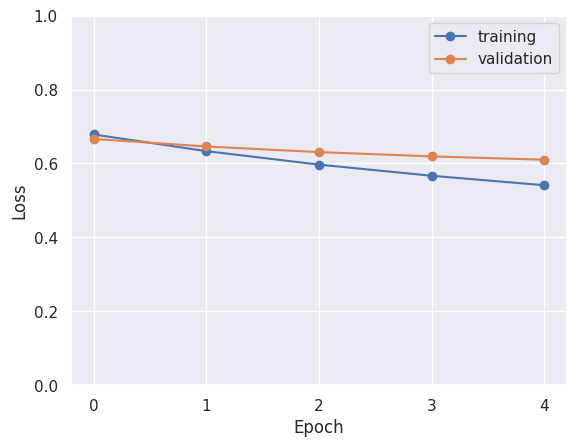

In [ ]:
model1 = build_onehot_model()

# Fit the model.
history1 = model1.fit(
  x = X_train_one_hot,  # one-hot training data
  y = Y_train,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

model1.summary()
# Convert the return value into a DataFrame so we can see the train loss
# and binary accuracy after every epoch.
history1 = pd.DataFrame(history1.history)
plot_history(history1)

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5681 - loss: 0.6919 - val_accuracy: 0.6400 - val_loss: 0.6885
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6624 - loss: 0.6868 - val_accuracy: 0.6700 - val_loss: 0.6839
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6820 - loss: 0.6819 - val_accuracy: 0.6800 - val_loss: 0.6795
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6900 - loss: 0.6771 - val_accuracy: 0.6860 - val_loss: 0.6753
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6952 - loss: 0.6726 - val_accuracy: 0.6932 - val_loss: 0.6712


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ global_average_pooling1d        │ (None, 1000)           │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,005 (11.74 KB)

 Trainable params: 1,001 (3.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,004 (7.83 KB)

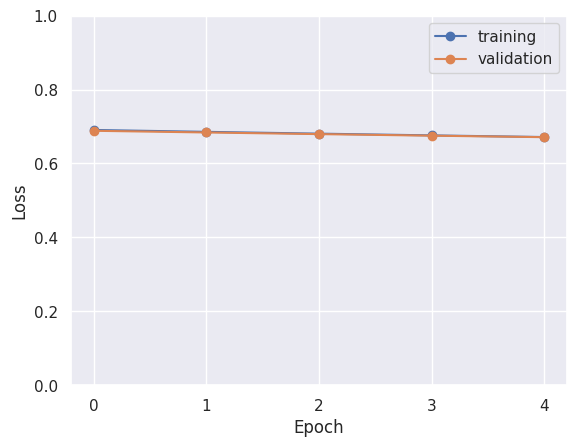

In [ ]:
model_avg = build_onehot_model(average_over_positions=True)

# Fit the model.
history_avg = model_avg.fit(
  x = X_train_one_hot,  # one-hot training data
  y = Y_train,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

model_avg.summary()
# Convert the return value into a DataFrame so we can see the train loss
# and binary accuracy after every epoch.
history_avg = pd.DataFrame(history_avg.history)
plot_history(history_avg)

### <span style="color:chocolate">Exercise 6:</span>  Comparing logistic regression models (20 points)

Train the one-hot model using both the concatenating and the averaging strategies and compare the results. Let's call these *LR-C* (Logistic Regression Concatenating) and *LR-A* (Logistic Regression Averaging). Then answer the following questions:

1. What are the final training and validation accuracies for LR-C and LR-A?
2. How many parameters are there in each model?
3. Would you say that either model is overfitting? Why or why not?
4. Briefly describe how LR-C differs from LR-A. How do you explain the relationship between their respective validation accuracy results?

*Written answer:*

1. For LR-C, the final training and validation accuracies are 0.8132 and 0.6832. For LR-A, the final training and validation accuracies are 0.6918 and 0.6856.

2. For LR-C, there are 60,005 parameters. For LR-A, there are 3,005 parameters.

3. LR-C may be overfitting. This is because there is a decrease in training loss while validation loss stays about the same. The accuracies are also largely different, with training accuracy being 81% and validation accuracy being 0.6856. It is not generalizing well and is overfitted.

4. LR-C and LR-A achieve similar validation accuracies because they're both constrained by the limited feature representation (20 tokens, 1000 vocab). However, LR-C is more stable and doesn't overfit, while LR-A shows overfitting with its training loss decreasing but validation loss staying flat. The averaging in LR-C acts as a regularizer, preventing overfitting without sacrificing accuracy.


### <span style="color:chocolate">Improvement over baseline:</span> Logistic regression with embeddings

Next, you will train a model that replaces one-hot representations of each token with learned embeddings.

The code below uses a Keras Embedding layer, which expects to receive a sparse (rather than one-hot) representation. That is, it expects a (padded) sequence of token ids; for each id, it looks up the corresponding embedding vector.

In [ ]:
def build_embeddings_model(average_over_positions=False,
                           vocab_size=1000,
                           sequence_length=20,
                           embedding_dim=2):
  """Build a tf.keras model using embeddings."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      input_length=sequence_length)
  )

  if average_over_positions:
    # This layer averages over the first dimension of the input by default.
    model.add(tf.keras.layers.GlobalAveragePooling1D())
  else:
    # Concatenate.
    model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      activation='sigmoid'         # apply the sigmoid function!
  ))

  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  return model

You will train this model, this time using the averaging strategy instead of the concatenating strategy for handling the token sequence. You'll look up the embedding vectors for each token and average them to produce a single vector. Then, you'll use this averaged vector to train a logistic regression model to predict the binary label.

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5796 - loss: 0.6901 - val_accuracy: 0.6604 - val_loss: 0.6777
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6794 - loss: 0.6700 - val_accuracy: 0.6916 - val_loss: 0.6520
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7005 - loss: 0.6412 - val_accuracy: 0.7028 - val_loss: 0.6251
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7108 - loss: 0.6124 - val_accuracy: 0.7072 - val_loss: 0.6025
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7180 - loss: 0.5880 - val_accuracy: 0.7124 - val_loss: 0.5850


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 20, 2)          │         2,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 2)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,011 (23.48 KB)

 Trainable params: 2,003 (7.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,008 (15.66 KB)

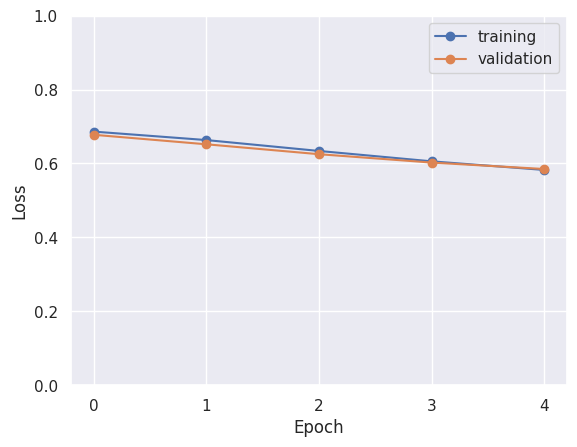

In [ ]:
X_train_reduced = np.array(X_train_reduced)

model2 = build_embeddings_model(average_over_positions=True,
                               vocab_size=1000,
                               sequence_length=20,
                               embedding_dim=2)
history2 = model2.fit(
  x = X_train_reduced,  # our sparse padded training data
  y = Y_train,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

model2.summary()

history2 = pd.DataFrame(history2.history)
plot_history(history2)

### <span style="color:chocolate">Exercise 7:</span> Embedding size tuning (20 points)

Experiment with embedding sizes {2, 4, 8, 16, 32, 64}, while keeping other settings fixed and using the averaging strategy instead of the concatenating strategy. Then:

1. Construct a table showing the training and validation accuracies for each model after 5 training epochs;
2. Calculate the number of parameters in each model;
3. Analyze whether learned embeddings improve performance compared to one-hot encoding, and explain why this might be the case.

*Written answer:*

1. | Embed Size | Training Accuracy | Validation Accuracy |
|-------|------------------|---------------------|
| 2 | 0.7180 | 0.7124 |
| 4 | 0.7263 | 0.7204 |
| 8 | 0.7410 | 0.7248 |
| 16 | 0.7513 | 0.7284 |
| 32 | 0.7549 | 0.7308 |
| 64 | 0.7578 | 0.7308 |

2. | Embed Size | Parameters |
|-------|--------------|
| 2 | 6,011 |
| 4 | 12,017 |
| 8 | 24,029 |
| 16 | 48,053 |
| 32 | 96,101 |
| 64 | 192,197 |

3. The learned embeddings show significant improvement over one-hot encoding:

  - One-hot encoding (LR-C and LR-A): Validation accuracy ~67-70%
  - Learned embeddings: Validation accuracy ranges from 71.2% (dim=2) to 73.1% (dim=32 and 64)

    This represents approximately **3-6% improvement** in validation accuracy.

    One-hot encoding creates sparse vectors, while embeddings create dense, low-dimensional vectors that capture semantic relationships between words. Similar words (like "good" and "great") end up with similar embeddings.

    Even a 2-dimensional embedding (6,011 parameters) outperforms the one-hot model. Higher dimensions (32-64) capture more nuanced word relationships with 48,053-96,101 parameters, still far more efficient than storing 1000-dimensional one-hot vectors.

    Embeddings are learned during training to optimize for the sentiment classification task. Words that are predictive of positive/negative sentiment are positioned meaningfully in the embedding space.

    The dense representations help the model generalize better to unseen reviews by capturing underlying semantic patterns rather than just memorizing specific word indices.

---

### Inspecting Learned Embeddings
You will now retrieve the learned embedding parameters from the trained model2 and plot the token embeddings.

The model layers in a Keras Sequential model are stored as a list and the embeddings are the first layer. You can use the <span style="color:chocolate">get_weights()</span> function to get a numpy array with the parameters.

In [ ]:
# Display the model layers.
display(model2.layers)

# Retrieve the embeddings layer, which itself is wrapped in a list.
embeddings2 = model2.layers[0].get_weights()[0]
display(embeddings2.shape)

[<Embedding name=embedding, built=True>,
 <GlobalAveragePooling1D name=global_average_pooling1d, built=True>,
 <Dense name=dense, built=True>]

(1000, 64)

Now you'll use a fancy plotting tool called *plotly* to show the embeddings with hovertext so you can move your mouse over the points to see the corresponding tokens.

In [ ]:
def plot_2d_embeddings(embeddings, id_start=1, count=100):
  # Get 1st and 2nd embedding dims for the desired tokens.
  x1 = embeddings[id_start:id_start+count, 0]
  x2 = embeddings[id_start:id_start+count, 1]

  # Get the corresponding words from the reverse index (for labeling).
  tokens = [reverse_index[i] for i in range(id_start, id_start+count)]

  # Plot with the plotly library.
  data = plotly.Scatter(x=x1, y=x2, text=tokens,
                        mode='markers', textposition='bottom left',
                        hoverinfo='text')
  fig = plotly.Figure(data=[data],
                      layout=plotly.Layout(title="Word Embeddings",
                                           hovermode='closest'))
  fig.show()

# Very frequent tokens tend to be more syntactic than semantic, so let's plot
# some rarer words.
plot_2d_embeddings(embeddings2, id_start=500, count=500)

### <span style="color:chocolate">Exercise 8:</span> Interpreting embeddings (20 points)

Notice that the 2-D embeddings fall in a narrow diagonal band. Answer the following questions:

1. Have the learned embeddings separated positive and negative words? What is the most negative word? Does this make sense?
2. Give 2 examples of words that seem to have surprising embedding values and try to explain their positions. For example, what's going on with the tokens '7', '8', and '9'? What are two other surprising results?
3. The embedding for 'crazy' is very close to (0,0). Explain what this means in terms of the model's output.
4. Can you explain what you think the 2 learned embedding dimensions mean, if anything?

1. The learned embeddings have separated the positive and negative words. The positive words are towards the upper part of the diagonal and the negative words are towards the lower part. The most negative word is "avoid" which makes a lot of sense ("avoid this movie" etc.).

2. The tokens '7', '8' and '9' seem to have positive embedding values. This could be because all these numbers are considered ratings out of 10, and are above 5, which means the movie would be considered above mediocre. The reason 7 would appear more positive is likely because it is a rating that is given out a lot more than an 8 or 9. "Today" is another one which appears to be positive but I would expect it to be neutral. Reviews like "This movie is still good today" may be present in the dataset and skew the results for the word "today" to be considered positive. "Unless" is another word which is not negative on its own, but is overwhelmingly negative. Reviews like "I wouldn't watch this unless I was forced to" may skew its embedding value.

3. "Crazy" being very close to neutral indicates that the training dataset has reviews containing positive phrases like "crazy amazing" but also negative ones like "crazy stupid." This means crazy appears equally in positive and negative sentiment.

4. The x-axis appears to represent sentiment polarity- the primary feature separating positive and negative words. Positive words like "good", "great", "amazing" and high numbers like "7", "8", "9" appear on one end, while negative words like "bad", "terrible", "boring" appear on the other end.

    The y-axis appears to capture sentiment polarity or a highly correlated feature.

----
#### <span style="color:chocolate">Additional practice question</span> (not graded)

More data and bigger models

Remember how you limited your input sequences to 20 tokens and 1000 vocabulary entries? Let's see how well you can do using more data and bigger models (more parameters).

Using pieces of code from above, set up and train a model to achieve at least 80% accuracy on both training and validation data. Ensure the following elements are included:

1. Truncate and pad input to the desired length;
2. Limit the vocabulary to the desired size;
3. Set up a model using embeddings;
4. Use the averaging strategy rather than the concatenating strategy;
5. Add additional layer(s) after the GlobalAveragePooling1D layer and before the output layer;
6. Evaluate the model's performance on the test data and comment on its generalization performance. Hint: remember to apply the same preprocessing to the test data. Use the <span style="color:chocolate">model.evaluate()</span> function for the final evaluation.

In [ ]:
# YOUR CODE HERE